In [9]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [10]:
RS = 42

In [23]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state=RS, train_size=0.8)
cnt_1 = Y_train[Y_train == 1].size
cnt_0 = Y_train[Y_train == 0].size
weight_for_1 = cnt_0 / cnt_1
weight_for_1

8.870324662996014

## 1. Влияние весов классов на метрики

In [12]:
params = {"max_depth": 5, "max_iter": 300, "learning_rate": 0.01}

draw_data = []

for _weight_for_1 in [weight_for_1 * (i / 100) for i in range(20, 200, 5)]:
  class_weight = {0: 1, 1: _weight_for_1}

  clf = HistGradientBoostingClassifier(**params, class_weight=class_weight)
  clf.fit(X_train, Y_train)
  draw_data.append(metrics(clf.predict(X_test), Y_test, output=False))
  draw_data[-1]["weight"] = _weight_for_1

Best weight for F1 score: 3. 
Best F1 score: 0.5944980350125044


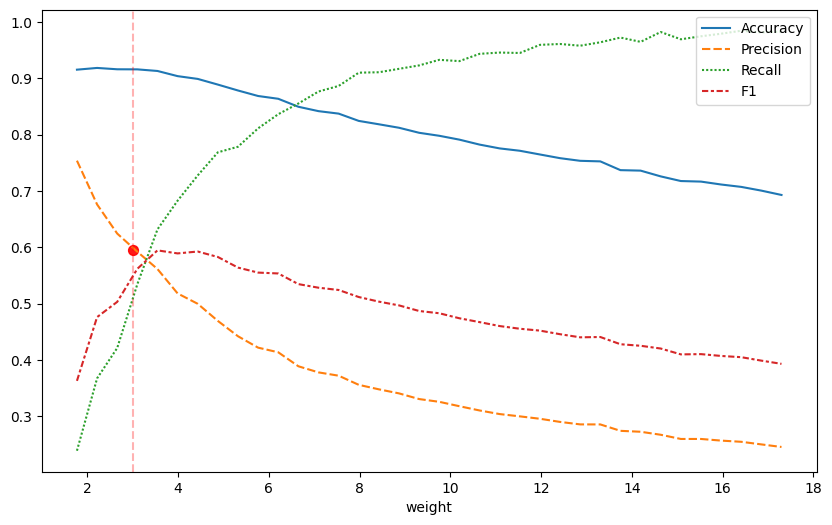

In [13]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["weight"])

best_weight_f1 = int(draw_df["F1"].idxmax())
best_f1 = draw_df["F1"].max()

print(f"Best weight for F1 score: {best_weight_f1}. \nBest F1 score: {best_f1}")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df)

plt.legend(loc="upper right")

# Highlight the best point
ax.axvline(x=best_weight_f1, color='red', linestyle='--', alpha=0.3)
ax.scatter(x=best_weight_f1, y=best_f1, color='red', s=50, alpha=0.9)

plt.show()

#### Видно, что веса довольно сильно влияют

## 2. Влияние разбиения датасета на метрики

In [28]:
params = {"max_depth": 5, "max_iter": 300, "learning_rate": 0.01}

draw_data = []

N = Y_train[Y_train == 1].size  # number of variable stars
new_train = pd.concat([X_train, Y_train], axis=1)

print(new_train.head())

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])

  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = HistGradientBoostingClassifier(**params)
  clf.fit(X, Y)
  
  draw_data.append(metrics(clf.predict(X_test), Y_test, output=False))
  draw_data[-1]["ratio"] = r

       e_Vmag    Bmag  e_Bmag   gpmag  e_gpmag   rpmag  e_rpmag   ipmag  \
43528   0.026  11.143   0.037  10.939    0.087  10.718    0.005  10.680   
865     0.000   9.281   0.000   9.587    0.833   8.738    0.000   8.666   
57090   0.021  13.062   0.026  12.774    0.021  12.452    0.038  12.384   
38860   0.020  15.837   0.107  15.293    0.008  14.628    0.019  14.383   
14950   0.017  16.000   0.033  15.498    0.047  14.739    0.031  14.402   

       e_ipmag  fuv_mag  nuv_mag       err  min_mag  max_mag  present  
43528    0.018   18.370   14.145  0.099815    14.78    14.85        0  
865      0.000   18.129   13.258  0.833000     8.33     0.95        0  
57090    0.039   22.429   16.166  0.067253    14.43    14.46        0  
38860    0.005   23.548   21.380  0.110901    11.11    11.15        0  
14950    0.186   19.161   18.387  0.197848    16.26    16.40        0  


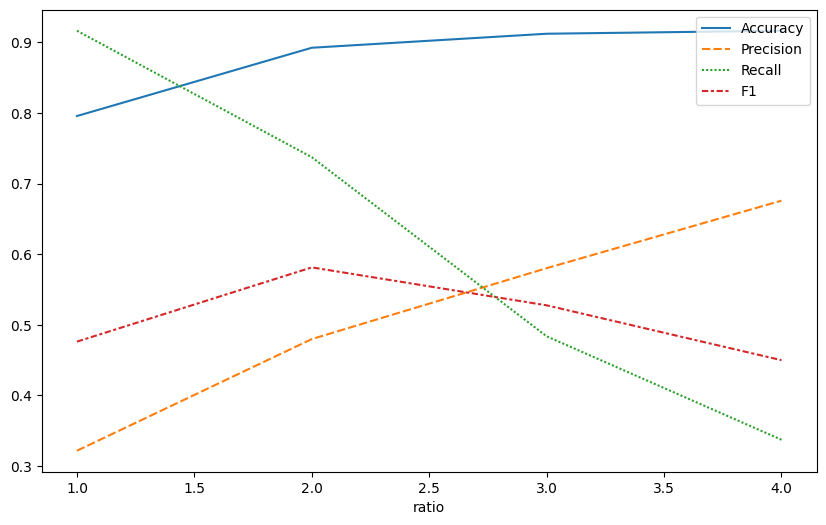

In [29]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["ratio"])
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df)

plt.legend(loc="upper right")

plt.show()

## 3. Лучший Learning rate

In [30]:

weight_for_1 = best_weight_f1

class_weight = {0: 1, 1: weight_for_1}

params = {"max_depth": 5, "max_iter": 300, "class_weight": class_weight}

draw_data = []

for lr in [i / 1000 for i in range(1, 1000, 10)]:
  clf = HistGradientBoostingClassifier(**params, learning_rate=lr)

  clf.fit(X_train, Y_train)

  pred = clf.predict(X_test)

  metrics(pred, Y_test, output=False)
  
  draw_data.append(metrics(pred, Y_test, output=False))
  draw_data[-1]["Learning rate"] = lr

Best learning rate for F1 score: 0.301
Best F1 score: 0.7625


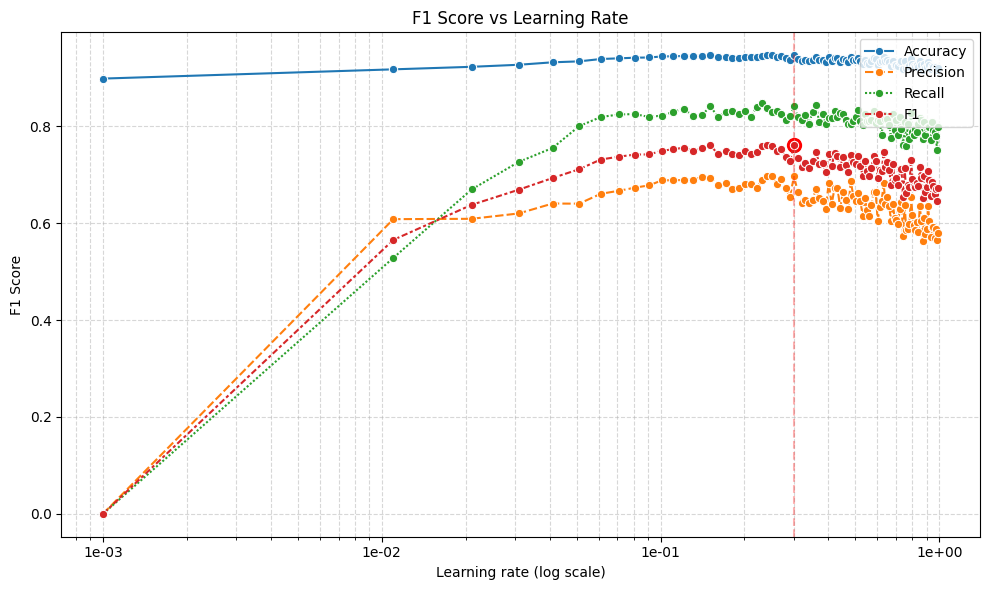

In [31]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index("Learning rate")

# Find best learning rate
best_lr = draw_df['F1'].idxmax()
best_f1 = draw_df['F1'].max()

print(f"Best learning rate for F1 score: {best_lr}\nBest F1 score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df, marker='o')

ax.set_xscale('log')
ax.set_xlabel('Learning rate (log scale)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score vs Learning Rate')

ax.axvline(x=best_lr, color='red', linestyle='--', alpha=0.3)
ax.scatter(x=best_lr, y=best_f1, color='red', s=100)

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Improve tick formatting
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Пример с работы модели с настроенными параметрами

Accuracy:   0.9376779256751558
Precision:  0.6504451038575668
Recall:     0.8321943811693242
F1:         0.7301798800799467


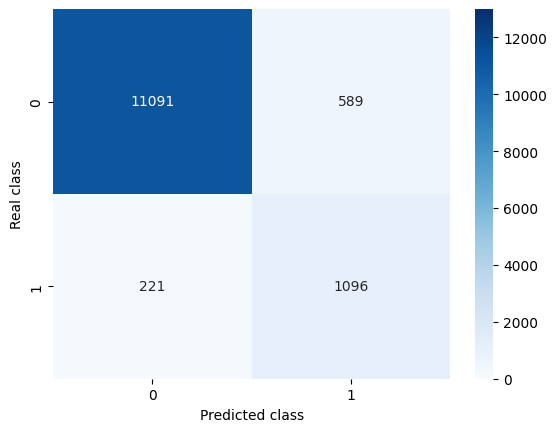

In [32]:
params = {"max_iter": 300, "max_depth": 5, "learning_rate": best_lr, "class_weight": {0: 1, 1:best_weight_f1}}

clf = HistGradientBoostingClassifier(**params)

clf.fit(X_train, Y_train)

pred = clf.predict(X_test)

metrics(pred, Y_test, False)